# Домашнее задание по теме Audio Processing

## Spoken Language Processing
В этом задании предлагается обучить классификатор класса возраста по голосу (пример с тем, как это можно сделать для пола см. в семинаре)

Подумайте, как лучше предсказывать возраст (может быть разбить на группы?) и какой лосс использовать

# Задание 1
Загрузите данные для обучения. Для этого:
1. Скачайте датасет TIMIT (см семинар)
2. Соберите пары "голос"  — "класс возраста" также, как на семинаре собирались пары "голос"  — "пол". Аудиодорожки сконвертируйте в мелспектрограммы при помощи `torchaudio либо` `librosa`

**Решение:**
- Код из семинара не использовался (за исключением архитектурной концепции Baseline модели)
- Вместо библиотеки librosa использован torchaudio
- Решение выполнено на spectrogram power=1
- Использована [статья](https://jonathanbgn.com/2021/08/30/audio-augmentation.html) в части создания класса для добавления случайного шума к волне

## Установка библиотек и загрузка данных

In [ ]:
!pip3 install timit-utils==0.9.0
!pip3 install torchaudio
! wget https://ndownloader.figshare.com/files/10256148
!unzip -q 10256148

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for python-speech-features: filename=python_speech_features-0.6-py3-none-any.whl size=5889 sha256=ed4453eace7d992d19d6bed7e9ba35220adc4f36d68ae04d2bd92df5789eb01d
  Stored in directory: /root/.cache/pip/wheels/5b/60/87/28af2605138deac93d162904df42b6fdda1dab9b8757c62aa3
Successfully built python-speech-features
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
--2023-03-04 13:02:59--  https://ndownloader.figshare.com/files/10256148
Resolving ndownloader.figshare.com (ndownloader.figshare.com)... 54.217.124.219, 52.16.102.173, 2a05:d018:1f4:d003:1c8b:1823:acce:812, ...
Connecting to ndownloader.figshare.com (ndownloader.figshare.com)|54.217.124.219|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://s3-eu-west-1.amazonaws.com/pfigshare-u-files/10256148

## Импорт библиотек

In [ ]:
import timit_utils as tu
import os
import librosa
import pandas as pd
import numpy as np
import random
import math
from tqdm.notebook import tqdm
import gc
import IPython
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
import torchaudio.transforms as T
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", font_scale=1.05)

from sklearn.metrics import accuracy_score, f1_score


_TIMIT_PATH = os.path.abspath('/content/data/lisa/data/timit/raw/TIMIT')

In [ ]:
# Будем читать случайный шум и сохранять веса моделей на диск
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Папка со случайными шумами, которые были использованы для аугментации, доступна по [ссылке](https://drive.google.com/drive/folders/1U_0a3s1nhjj6yClhUvhi-cDm0eJmw5Hl?usp=share_link)

In [ ]:
# Для дальнейшей работы нам понадобятся следующие пути
MODELS_DIR = os.path.abspath('/content/drive/MyDrive/DLS_NLP/8w_audio')
NOISE_DIR = os.path.join(MODELS_DIR, 'noises_sounds')

In [ ]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
!nvidia-smi

Sat Mar  4 13:04:51 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8    10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Подготовка датасета



### Исследование Timit Dataset

#### Класс по информации о спикерах

In [ ]:
# Класс, который создает DataFrame с информацией о спикерах и путями к их аудио-файлам
class TimitDataFrame:
    def __init__(self, data_path=_TIMIT_PATH, val_size=0.10):
        self.data_path = data_path
        self.val_size = val_size
        self.full_data = self.create_dataframe()

    @staticmethod
    def age_class(age):
        if age < 25:
            return 0
        if age > 40:
            return 2
        else:
            return 1

    def create_dataframe(self):
        # Читаем информацию о спикерах
        doc_file_path = os.path.join(self.data_path, 'DOC', 'SPKRINFO.TXT')
        with open(doc_file_path) as f:
            rows = [row.replace(';', '').replace('??', '50').strip().split()[:9] for row in f.readlines()[37:]]

        # Создаем DataFrame с информацией о спикерах
        df = pd.DataFrame(columns=rows[0], data=rows[2:])
        df['DR'] = df['DR'].astype(str)

        # Переименовываем сущности в колонке Use, чтобы они соответствовали названиям папок
        df.loc[df.Use == 'TST', 'Use'] = 'TEST'
        df.loc[df.Use == 'TRN', 'Use'] = 'TRAIN'

        # Считаем возраст и создаем колонку с классом возраста
        df['age'] = df['RecDate'].str[-2:].astype(int) - df['BirthDate'].str[-2:].astype(int)
        df['labels'] = df['age'].map(self.age_class)

        # Создаем колонку с путем к WAV файлам
        df['full_path'] = df.Use.astype(str) + '/DR' + df.DR.astype(str) + '/' + df.Sex.astype(str) + df.ID.astype(str)

        # Отбираем 15% train спикеров для валидации
        num_val = int(len(df[df.Use == 'TRAIN']) * self.val_size)
        ind = df[df.Use == 'TRAIN'].sample(num_val).index
        df.loc[ind, 'Use'] = 'VAL'
        df['wav_files'] = None

        # Создаем список аудиозаписей каждого спикера
        for ind, row in df.iterrows():
            wav_files = []
            path = os.path.join(self.data_path, df.loc[ind, 'full_path'])
            for f in os.listdir(path):
                if f.endswith('.WAV'):
                    wav_files.append(f)
            df.at[ind, 'wav_files'] = wav_files

        return df

    def return_dataset(self, mode='TRAIN'):
        assert mode in ['TRAIN', 'VAL', 'TEST']
        df = self.full_data[self.full_data.Use == mode].copy()
        # Разворачиваем DataFrame, чтобы каждому аудифайлу соответствовала своя строка со всеми атрибутами
        return df.explode('wav_files', ignore_index=True)

In [ ]:
# функция, которая загружает загружает аудиофайл по индексу
def load_sample(data_path, data, ind):
        path = os.path.join(data_path, data.loc[ind, 'full_path'], data.loc[ind, 'wav_files'])
        wav_file, sr = torchaudio.load(path, normalize=True)
        resample_transform = T.Resample(sr, 16000)
        wav_file = resample_transform(wav_file)
        return wav_file

#### Статистики по датасету

In [ ]:
# Создадим DataFrame с информацей по спискерам из train-выборки
timit_df = TimitDataFrame()
train_df = timit_df.return_dataset(mode='TRAIN')
train_df.head()

,ID,Sex,DR,Use,RecDate,BirthDate,Ht,Race,Edu,age,labels,full_path,wav_files
0,ABC0,M,6,TRAIN,03/03/86,06/17/60,"5'11""",WHT,BS,26,1,TRAIN/DR6/MABC0,SX421.WAV
1,ABC0,M,6,TRAIN,03/03/86,06/17/60,"5'11""",WHT,BS,26,1,TRAIN/DR6/MABC0,SA2.WAV
2,ABC0,M,6,TRAIN,03/03/86,06/17/60,"5'11""",WHT,BS,26,1,TRAIN/DR6/MABC0,SI1620.WAV
3,ABC0,M,6,TRAIN,03/03/86,06/17/60,"5'11""",WHT,BS,26,1,TRAIN/DR6/MABC0,SA1.WAV
4,ABC0,M,6,TRAIN,03/03/86,06/17/60,"5'11""",WHT,BS,26,1,TRAIN/DR6/MABC0,SX331.WAV


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4160 entries, 0 to 4159
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         4160 non-null   object
 1   Sex        4160 non-null   object
 2   DR         4160 non-null   object
 3   Use        4160 non-null   object
 4   RecDate    4160 non-null   object
 5   BirthDate  4160 non-null   object
 6   Ht         4160 non-null   object
 7   Race       4160 non-null   object
 8   Edu        4160 non-null   object
 9   age        4160 non-null   int64 
 10  labels     4160 non-null   int64 
 11  full_path  4160 non-null   object
 12  wav_files  4160 non-null   object
dtypes: int64(2), object(11)
memory usage: 422.6+ KB


In [ ]:
# Посмотрим, какой длины аудиофайлы представлены в train-выборке
sizes = []
for i in range(len(train_df)):
  size = load_sample(_TIMIT_PATH, train_df, i).shape[1]
  sizes.append(size)

In [ ]:
min(sizes), max(sizes)

(14644, 124621)

In [ ]:
# Статистики по длинам аудиозаписей
pd.Series(sizes).describe()

count      4160.000000
mean      49111.807452
std       13791.988429
min       14644.000000
25%       39834.000000
50%       47104.000000
75%       56730.000000
max      124621.000000
dtype: float64

In [ ]:
# Размер выборки с длиной аудиозаписи до 70000 (при sample rate = 16000)
(pd.Series(sizes) < 70000).sum() * 100 / len(sizes)

91.1298076923077

91% аудиозаписей будут иметь длину до 70000.

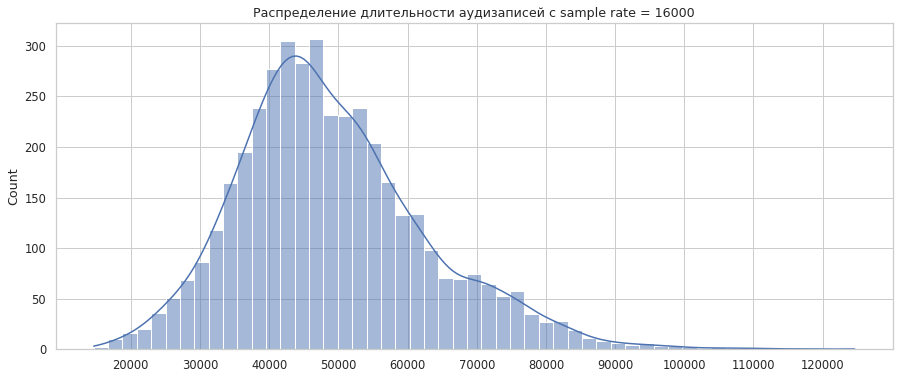

In [ ]:
plt.figure(figsize=(15,6))
sns.histplot(x=sizes, kde=True)
plt.xticks([i * 10000 for i in range(2, 13)])
plt.title('Распределение длительности аудизаписей с sample rate = 16000')
plt.show()

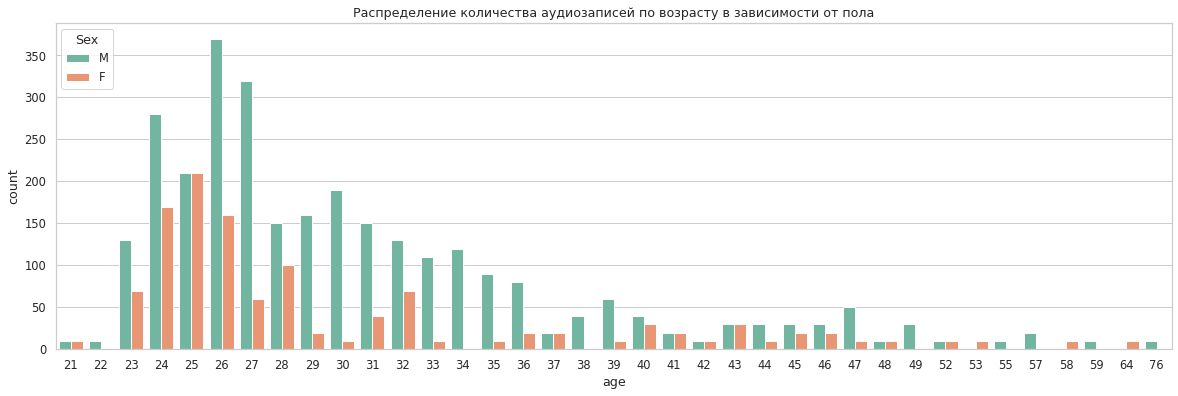

In [ ]:
plt.figure(figsize=(20,6))
a = sns.countplot(x='age', data=train_df, hue='Sex', palette='Set2')
a.set_title('Распределение количества аудиозаписей по возрасту в зависимости от пола')
plt.show()

- Мужских голосов значительно больше, чем женских.
- Большинство примеров относится к возрасту 24-27 лет
- Не имеют женских голосов спикеры возраста: 22, 34, 38, 49, 55, 57 лет
- Датасет не содержит спикеров в возрасте: до 21 года, 50-51 год, 54 года, 56 лет, 60-63 года, 65-75 лет и более 76 лет.
- Любое разделение на 3 класса по возрасту будет не стратифицировано по возрасту и не сбалансировано по размерам классов

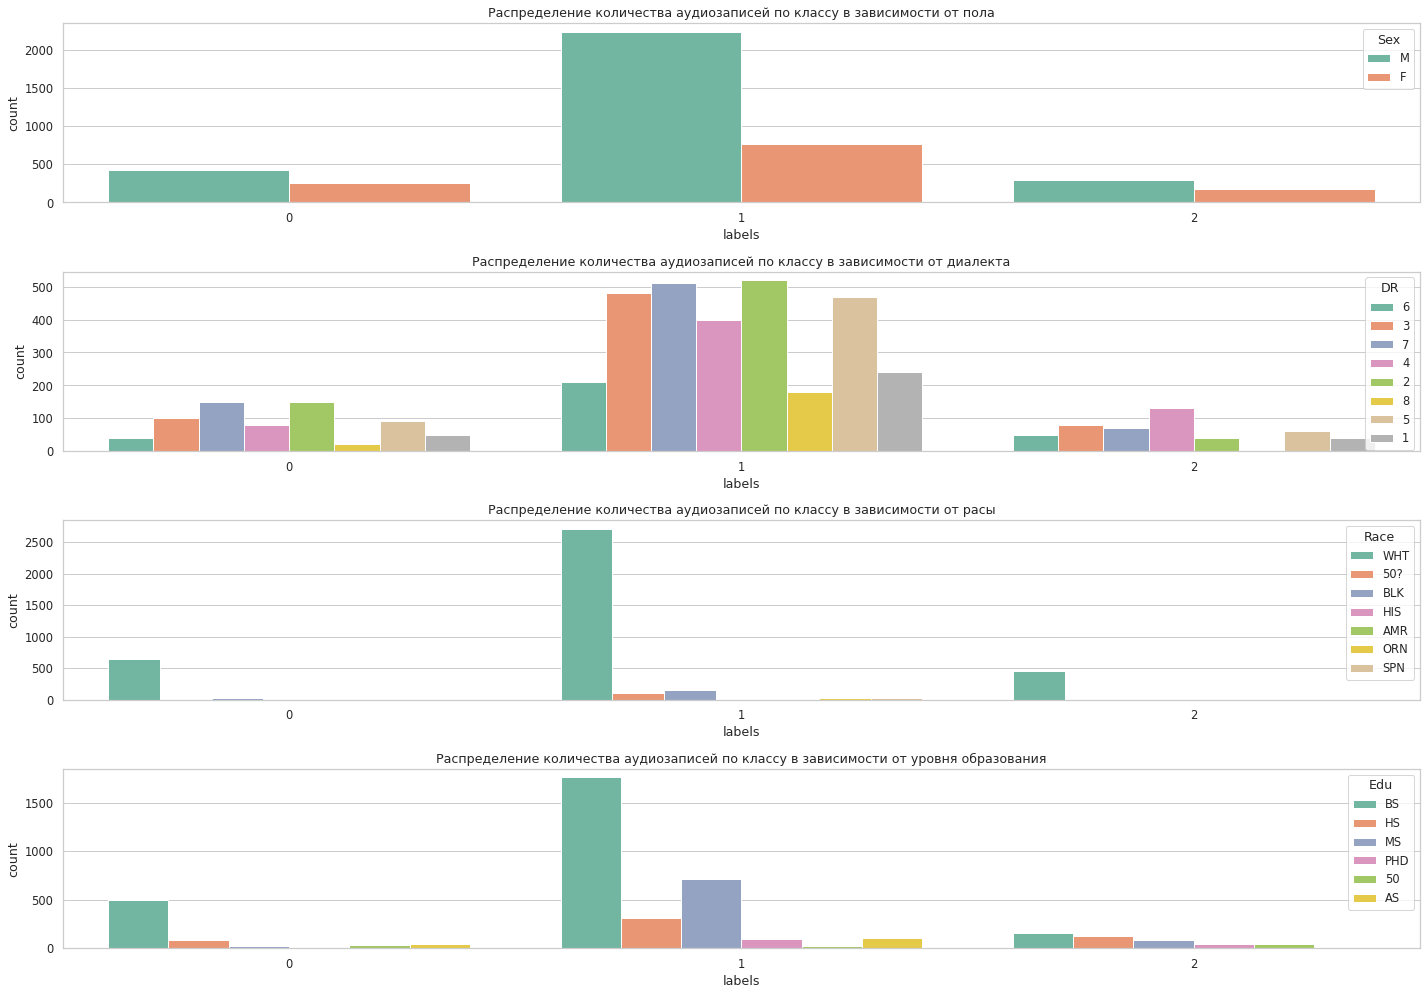

In [ ]:
fig, axes = plt.subplots(4, 1, figsize=(20,14))
p1 = sns.countplot(x='labels', data=train_df, hue='Sex', ax=axes[0], palette='Set2')
p1.set_title('Распределение количества аудиозаписей по классу в зависимости от пола')
p2 = sns.countplot(x='labels', data=train_df, hue='DR', ax=axes[1], palette='Set2')
p2.set_title('Распределение количества аудиозаписей по классу в зависимости от диалекта')
p3 = sns.countplot(x='labels', data=train_df, hue='Race', ax=axes[2], palette='Set2')
p3.set_title('Распределение количества аудиозаписей по классу в зависимости от расы')
p4 = sns.countplot(x='labels', data=train_df, hue='Edu', ax=axes[3], palette='Set2')
p4.set_title('Распределение количества аудиозаписей по классу в зависимости от уровня образования')
fig.tight_layout()

#### Заключения

- Разделение по классам выбрано следующим образом:
  - 0 класс - спикеры, возрастом < 25 лет
  - 1 класс - спикеры, возрастом >= 25 лет и <= 40 лет
  - 2 класс - спикеры, возрастом > 40 лет
- 1 класс наиболее многочисленный
- Классы не сбалансированы по диалектам
- Представителей белой расы значительно больше, чем всех остальных во всех классах.
- Вся выборка и классы не сбалансированы по уровню образования
- Кажется, что определить, 24 или 25 лет (40 или 41 год) человеку не представляется возможным. Особенно, если эти люди разного пола, говорят на разном диалекте, имеют разную расу и уровень образования.
- Кажется, что рост спикера может влиять на его возраст. Но и без этого признака ясно, что хорошую точность получить нельзя.

Думаю, что задача - отделить ребенка от взрослого представляется более перспективной, чем отделить людей в возрасте 21-24 года от людей в возрасте 25-40 лет.

В связи с размером и особенностями выборки, я рассматриваю задачу настоящего домашнего задания в следующей интерпретации: **Посмотрите на некоторые подходы к обработке аудио, потренируйтесь обрабатывать аудио**

### Классы для загрузки и обработки аудио

#### Классы для аугментаций на сырой волне

In [ ]:
# Класс, который добавляет случайный шум к сырой волне
class RandomBackgroundNoise:
    def __init__(self, noise_dir, sample_rate=16000, min_snr_db=0, max_snr_db=15):
        self.sample_rate = sample_rate
        self.min_snr_db = min_snr_db
        self.max_snr_db = max_snr_db
        self.noise_dir = noise_dir
        self.noise_files_list = os.listdir(noise_dir)

    def __call__(self, audio_data):
        p = random.choice(list(range(5)))
        if not p:
            return audio_data
        random_noise_file = os.path.join(self.noise_dir, random.choice(self.noise_files_list))
        effects = [
            ['remix', '1'], # convert to mono
            ['rate', str(self.sample_rate)] # resample
        ]
        noise, _ = torchaudio.sox_effects.apply_effects_file(random_noise_file, effects, normalize=True)
        audio_length = audio_data.shape[-1]
        noise_length = noise.shape[-1]
        if noise_length > audio_length:
            offset = random.randint(0, noise_length-audio_length)
            noise = noise[..., offset:offset+audio_length]
        elif noise_length < audio_length:
            noise = torch.cat([noise, torch.zeros((noise.shape[0], audio_length-noise_length))], dim=-1)

        snr_db = random.randint(self.min_snr_db, self.max_snr_db)
        snr = math.exp(snr_db / 10)
        audio_power = audio_data.norm(p=2)
        noise_power = noise.norm(p=2)
        scale = snr * noise_power / audio_power

        return (scale * audio_data + noise ) / 2

In [ ]:
# Класс, который увеличивает громкость сырой волны
class RandomVolume:
  def __init__(self):
        self.gain_type = 'amplitude'

  def __call__(self, audio_data):
        gain = random.choice(np.linspace(0.1, 2, 20))
        transform = T.Vol(gain=gain, gain_type=self.gain_type)
        return transform(audio_data)

In [ ]:
# Класс, который собирает трансформации над сырой волной
class ComposeTransform:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, audio_data):
        for t in self.transforms:
            audio_data = t(audio_data)
        return audio_data

#### Класс для датасета

In [ ]:
class Timit_Dataset(Dataset):
    def __init__(self, data: pd.DataFrame, mode, noise_dir=NOISE_DIR, data_path: str =_TIMIT_PATH, sr: int = 16000, max_length=70000):
        super().__init__()
        # Источник аудио-файлов
        self.data_path = data_path
        self.data = data
        self.sr = sr
        self.noise_dir = noise_dir
        self.max_length = max_length
        self.mode = mode
        assert self.mode in ['TRAIN', 'VAL', 'TEST']
        self.len_ = len(self.data)
        self.transforms = ComposeTransform([
              RandomVolume(),
              RandomBackgroundNoise(self.noise_dir, self.sr)
              ])
        self.spectrogram = T.Spectrogram(
              n_fft=320,
              hop_length=160,
              center=True,
              pad=8,
              pad_mode="reflect",
              power=1,
              normalized=True
              )

    def __len__(self):
        return self.len_


    def cut_audio(self, wav_file):
        if wav_file.shape[-1] >= self.max_length:
          return wav_file[:, :self.max_length]
        # если аудио короче нужной длины, то воспроизводим его до нужной длины
        rep = math.ceil(self.max_length/wav_file.shape[-1])
        return wav_file.repeat(1, rep)[:, :self.max_length]


    def load_sample(self, ind):
        path = os.path.join(self.data_path, self.data.loc[ind, 'full_path'], self.data.loc[ind, 'wav_files'])
        wav_file, sr = torchaudio.load(path, normalize=True)
        resample_transform = T.Resample(sr, self.sr)
        wav_file = resample_transform(wav_file)
        # Обрезаем / удлинняем wav_file
        wav_file = self.cut_audio(wav_file)
        return wav_file


    @staticmethod
    def timemask(waveform):
        rep = np.random.choice(10)
        for i in range(rep):
          time_mask_param = np.random.choice(20)
          transform = T.TimeMasking(time_mask_param=time_mask_param)
          waveform = transform(waveform)
        return waveform


    @staticmethod
    def freqmask(waveform):
        rep = np.random.choice(10)
        for i in range(rep):
          freq_mask_param = np.random.choice(10)
          transform = T.FrequencyMasking(freq_mask_param=freq_mask_param)
          waveform = transform(waveform)
        return waveform


    def __getitem__(self, ind):
        # Получаем сырую волну и класс
        wav_file = self.load_sample(ind)
        label = torch.tensor(self.data.loc[ind, 'labels'], dtype=torch.long)

        # Для train применяем аугментации на сырой волне
        if self.mode == 'TRAIN':
            wav_file = self.transforms(wav_file)

        # преобразовываем в MelSpectrogram
        waveform = self.spectrogram(wav_file) # [1, 161, 438]

        # Для train применяем аугментации на спектрограмме
        if self.mode == 'TRAIN':
            waveform = self.timemask(waveform)
            waveform = self.freqmask(waveform)

        return waveform, label


    def _prepare_sample(self, raw_audio, sr=16000, raw_augs=False, spec_augs=False):
        resample_transform = T.Resample(sr, self.sr)
        wav_file = resample_transform(raw_audio)
        # Обрезаем / удлинняем wav_file
        wav_file = self.cut_audio(wav_file)
        # Нужны ли аугментации на сырой волне
        if raw_augs:
            wav_file = self.transforms(wav_file)

        waveform = self.spectrogram(wav_file)
        # Нужны ли аугментации на спектрограмме
        if spec_augs:
            waveform = self.timemask(waveform)
            waveform = self.freqmask(waveform)
        return waveform

## Datasets, Dataloaders

In [ ]:
# Данные
timit_df = TimitDataFrame()
train_df = timit_df.return_dataset(mode='TRAIN')
valid_df = timit_df.return_dataset(mode='VAL')
test_df = timit_df.return_dataset(mode='TEST')

print('Размер train выборки: ', len(train_df))
print('Размер valid выборки: ', len(valid_df))
print('Размер test выборки: ', len(test_df))

Размер train выборки:  4160
Размер valid выборки:  460
Размер test выборки:  1680


In [ ]:
# Датасеты
trainset = Timit_Dataset(train_df, mode='TRAIN')
validset = Timit_Dataset(valid_df, mode='VAL')
testset = Timit_Dataset(test_df, mode='TEST')

In [ ]:
# Dataloaders
batch_size=128
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(validset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)

In [ ]:
waveform, label = next(iter(train_loader))
print('Размер одного батча:', waveform.shape)

Размер одного батча: torch.Size([128, 1, 161, 438])


# Задание 2
1. Обучите свой классификатор категории возраста
2. Попробуйте улучшить результат. Можно попробовать усложнить сетку, подвигать границы категорий, поискать новые данные, что угодно, кроме учиться на тесте :)
3. Какой подход оказался самым эффективным? Как думаете, почему?
4. Как считаете, где можно было бы применить такой классификатор в качестве вспомогательной задачи?


## Baseline

Архитектура, предложенная в задании, была переписана в связи с изменениями входных размеров. Сохранен общий смысл

In [ ]:
class BaseModel(nn.Module):
    def __init__(self, window_sizes=(3, 4, 5)):
        super(BaseModel, self).__init__()

        self.convs = nn.ModuleList([
            nn.Conv2d(1, 161, [161, window_size], padding=(0, window_size - 1))
            for window_size in window_sizes
        ])

        self.fc = nn.Linear(161 * len(window_sizes), 3)

    def forward(self, x):
        #[B, 1, 161, 438]
        xs = []
        for conv in self.convs:
            x2 = F.relu(conv(x))  # [B, 161, 1, T]
            x2 = torch.squeeze(x2, 2)  # [B, 161, T]
            x2 = F.max_pool1d(x2, x2.size(2))  # [B, 161, 1]
            xs.append(x2)
        x = torch.cat(xs, 2)  # [B, 161, windows]

        # FC
        x = x.view(x.size(0), -1)  # [B, F * windows]
        logits = self.fc(x)  # [B, class]
        return logits

### CNNModel

Архитектура похожа на Baseline, но:
- добавлен еще один блок сверток с kernel = 10
- добавлены слои сверток Conv1d
- добавлены слои BatchNorm
- увеличен линейный слой, добавлены слои Dropout

In [ ]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        self.conv3 = nn.Sequential(
            nn.Conv2d(1, 160, [161, 3], padding=(0, 0)), # B x 160 x 1 x 436
            nn.Flatten(start_dim=2),
            nn.BatchNorm1d(160),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=3, stride=2, padding=0), # B x 160 x 217
            nn.Conv1d(160, 320, 3, padding=0), # B x 320 x 215
            nn.BatchNorm1d(320),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=3, stride=2, padding=0), # B x 320 x 107
            nn.Conv1d(320, 480, 3, padding=0), # B x 480 x 105
            nn.BatchNorm1d(480),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=3, stride=2, padding=0), # B x 480 x 52
            nn.Conv1d(480, 640, 52, padding=0),
            nn.BatchNorm1d(640),
            nn.ReLU()
            # out B x 640 x 1
            )

        self.conv4 = nn.Sequential(
            nn.Conv2d(1, 160, [161, 4], padding=(0, 0)), # B x 160 x 1 x 435
            nn.Flatten(start_dim=2),
            nn.BatchNorm1d(160),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=4, stride=2, padding=0), # B x 160 x 216
            nn.Conv1d(160, 320, 4, padding=0), # B x 320 x 213
            nn.BatchNorm1d(320),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=4, stride=2, padding=0), # B x 320 x 105
            nn.Conv1d(320, 480, 4, padding=0), # B x 480 x 102
            nn.BatchNorm1d(480),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=4, stride=2, padding=0), # B x 480 x 50
            nn.Conv1d(480, 640, 50, padding=0),
            nn.BatchNorm1d(640),
            nn.ReLU()
            # out B x 640 x 1
            )

        self.conv5 = nn.Sequential(
            nn.Conv2d(1, 160, [161, 5], padding=(0, 0)), # B x 160 x 1 x 434
            nn.Flatten(start_dim=2),
            nn.BatchNorm1d(160),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=5, stride=2, padding=0), # B x 160 x 215
            nn.Conv1d(160, 320, 5, padding=0), # B x 320 x 211
            nn.BatchNorm1d(320),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=5, stride=2, padding=0), # B x 320 x 104
            nn.Conv1d(320, 480, 5, padding=0), # B x 480 x 100
            nn.BatchNorm1d(480),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=5, stride=2, padding=0), # B x 480 x 48
            nn.Conv1d(480, 640, 48, padding=0),
            nn.BatchNorm1d(640),
            nn.ReLU()
            # out B x 640 x 1
            )

        self.conv10 = nn.Sequential(
            nn.Conv2d(1, 160, [161, 10], padding=(0, 0)), # B x 160 x 1 x 429
            nn.Flatten(start_dim=2),
            nn.BatchNorm1d(160),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=10, stride=2, padding=0), # B x 160 x 210
            nn.Conv1d(160, 320, 10, padding=0), # B x 320 x 201
            nn.BatchNorm1d(320),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=10, stride=2, padding=0), # B x 320 x 96
            nn.Conv1d(320, 480, 10, padding=0), # B x 480 x 87
            nn.BatchNorm1d(480),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=10, stride=2, padding=0), # B x 480 x 39
            nn.Conv1d(480, 640, 39, padding=0),
            nn.BatchNorm1d(640),
            nn.ReLU()
            # out B x 640 x 1
            )

        self.fc = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(640 * 4, 320 * 2),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(320 * 2, 320),
            nn.ReLU(),
            nn.Linear(320, 3)
            )

    def forward(self, x):
        # B x 1 x 161 x 438
        x3 = self.conv3(x).squeeze(-1)
        x4 = self.conv4(x).squeeze(-1)
        x5 = self.conv5(x).squeeze(-1)
        x10 = self.conv10(x).squeeze(-1)

        x = torch.cat((x3, x4, x5, x10), -1)  # [B, 640 * 4]
        # FC
        logits = self.fc(x)  # [B, 3]
        return logits

## Функции обучения

In [ ]:
from sklearn.metrics import f1_score, accuracy_score
import math
import time

def train(model, iterator, optimizer, criterion, clip,
          train_history=None, valid_history=None,
          train_f1_hist=None, valid_f1_hist=None,
          train_acc_hist=None, valid_acc_hist=None):

    model.train()
    history = []

    epoch_loss = 0
    epoch_truelables = torch.Tensor()
    epoch_preds = torch.Tensor()
    for i, (input, labels) in enumerate(iterator):
        optimizer.zero_grad()
        input = input.to(device)
        labels = labels.to(device)
        output = model(input)

        loss = criterion(output, labels)
        loss.backward()
        if clip:
          torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        epoch_loss += loss.item()
        output = torch.argmax(output.detach().cpu(), dim=1)
        epoch_preds = torch.cat((epoch_preds, output))
        epoch_truelables = torch.cat((epoch_truelables, labels.cpu()))

        history.append(loss.cpu().data.numpy())

    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(25, 8))
    clear_output(True)
    ax[0].plot(history, label='train loss')
    ax[0].set_xlabel('Batch')
    ax[0].set_title('Train loss')
    ax[0].legend()
    if train_history is not None:
        ax[1].plot(train_history, label='general train history')
        ax[1].set_xlabel('Epoch')
        ax[1].legend()
    if valid_history is not None:
        ax[1].plot(valid_history, label='general valid history')
        ax[1].legend()
    if train_f1_hist is not None:
        ax[2].plot(train_f1_hist, label='train f1 history')
        ax[2].set_xlabel('Epoch')
        ax[2].legend()
    if valid_f1_hist is not None:
        ax[2].plot(valid_f1_hist, label='valid f1 history')
        ax[2].legend()
    if train_acc_hist is not None:
        ax[3].plot(train_acc_hist, label='train accuracy history')
        ax[3].set_xlabel('Epoch')
        ax[3].legend()
    if valid_acc_hist is not None:
        ax[3].plot(valid_acc_hist, label='valid accuracy history')
        ax[3].legend()
    plt.show()

    return epoch_loss / (i + 1), epoch_truelables.to(torch.int64).numpy(), epoch_preds.numpy()


def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    epoch_truelables = torch.Tensor()
    epoch_preds = torch.Tensor()

    with torch.no_grad():
        for i, (input, labels) in enumerate(iterator):
            input = input.to(device)
            labels = labels.to(device)
            output = model(input)

            loss = criterion(output, labels)

            epoch_loss += loss.item()
            output = torch.argmax(output.detach().cpu(), dim=1)
            epoch_preds = torch.cat((epoch_preds, output))
            epoch_truelables = torch.cat((epoch_truelables, labels.cpu()))

    return epoch_loss / (i + 1), epoch_truelables.to(torch.int64).numpy(), epoch_preds.numpy()


def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
def inference(model, test_loader):
    truelables = torch.Tensor()
    preds = torch.Tensor()
    model.eval()
    with torch.no_grad():
      for (input, labels) in tqdm(test_loader):
        input = input.to(device)
        labels = labels.to(device)
        output = model(input)
        output = torch.argmax(output.detach().cpu(), dim=1)
        preds = torch.cat((preds, output))
        truelables = torch.cat((truelables, labels.cpu()))

    test_f1 = f1_score(truelables.to(torch.int64).numpy(), preds.numpy(), average='weighted')
    print(f'F1-score on test dataset: {test_f1:.3f}')
    test_acc = accuracy_score(truelables.to(torch.int64).numpy(), preds.numpy())
    print(f'Accuracy score on test dataset: {test_acc:.3f}')

In [ ]:
def train_model(model, model_name, train_loader, valid_loader, optimizer, criterion, clip, N_EPOCHS):
    train_history = []
    valid_history = []
    train_f1_hist = []
    valid_f1_hist = []
    train_acc_hist = []
    valid_acc_hist = []

    best_valid_loss = float('inf')
    best_valid_f1 = 0

    for epoch in range(N_EPOCHS):
        start_time = time.time()

        train_loss, train_truelables, train_preds = train(model, train_loader, optimizer, criterion, clip,
                                                          train_history, valid_history,
                                                          train_f1_hist, valid_f1_hist,
                                                          train_acc_hist, valid_acc_hist)
        valid_loss, valid_truelables, valid_preds = evaluate(model, valid_loader, criterion)

        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), os.path.join(MODELS_DIR, f'best-loss-{model_name}.pt'))

        train_f1 = f1_score(train_truelables, train_preds, average='weighted')
        valid_f1 = f1_score(valid_truelables, valid_preds, average='weighted')
        train_acc = accuracy_score(train_truelables, train_preds)
        valid_acc = accuracy_score(valid_truelables, valid_preds)

        if valid_f1 > best_valid_f1:
            best_valid_f1 = valid_f1
            torch.save(model.state_dict(), os.path.join(MODELS_DIR, f'best-f1-{model_name}.pt'))

        train_history.append(train_loss)
        valid_history.append(valid_loss)
        train_f1_hist.append(train_f1)
        valid_f1_hist.append(valid_f1)
        train_acc_hist.append(train_acc)
        valid_acc_hist.append(valid_acc)

        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
        print(f'\t Train. F1: {train_f1:.3f} |  Val. F1: {valid_f1:.3f}')
        print(f'\t Train. Acc: {train_acc:.3f} |  Val. Acc: {valid_acc:.3f}')
        # gc.collect()
        # torch.cuda.empty_cache()

    torch.save(model.state_dict(), os.path.join(MODELS_DIR, f'last-{model_name}.pt'))
    return model

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

## Обучение и инференс Baseline

In [ ]:
model = BaseModel().to(device)
opt = torch.optim.Adam(model.parameters(), lr=2e-5)
loss_func = nn.CrossEntropyLoss()
CLIP = 10
N_EPOCHS = 20
model_name = 'basemobel'
model.eval()

BaseModel(
  (convs): ModuleList(
    (0): Conv2d(1, 161, kernel_size=(161, 3), stride=(1, 1), padding=(0, 2))
    (1): Conv2d(1, 161, kernel_size=(161, 4), stride=(1, 1), padding=(0, 3))
    (2): Conv2d(1, 161, kernel_size=(161, 5), stride=(1, 1), padding=(0, 4))
  )
  (fc): Linear(in_features=483, out_features=3, bias=True)
)

In [ ]:
print(f'The model has {count_parameters(model)} trainable parameters')

The model has 312987 trainable parameters


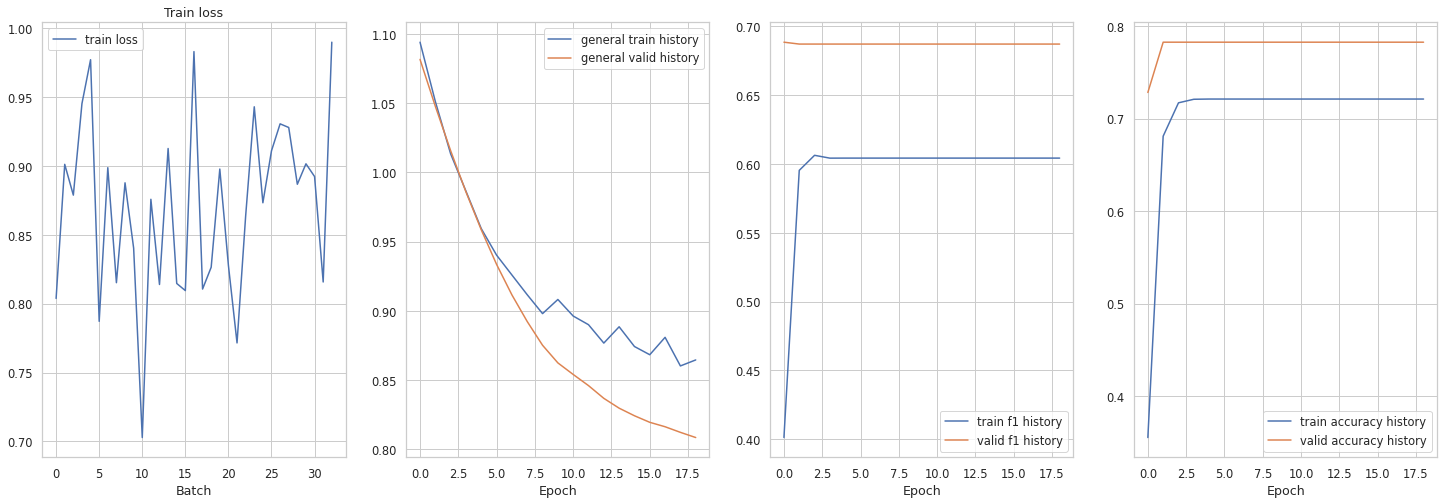

Epoch: 20 | Time: 1m 30s
	Train Loss: 0.870 | Train PPL:   2.387
	 Val. Loss: 0.805 |  Val. PPL:   2.236
	 Train. F1: 0.604 |  Val. F1: 0.687
	 Train. Acc: 0.721 |  Val. Acc: 0.783


In [ ]:
model = train_model(model, model_name, train_loader, val_loader, opt, loss_func, CLIP, N_EPOCHS)

In [ ]:
# Посчитаем метрики на тестовой выборке
print('Метрики, рассчитанные на тестовой выборке. Лучшая модель по loss')
model.load_state_dict(torch.load(os.path.join(MODELS_DIR, f'best-loss-{model_name}.pt')))
inference(model, test_loader)

Метрики, рассчитанные на тестовой выборке. Лучшая модель по loss


  0%|          | 0/14 [00:00<?, ?it/s]

F1-score on test dataset: 0.627
Accuracy score on test dataset: 0.738


In [ ]:
# Посчитаем метрики на тестовой выборке
print('Метрики, рассчитанные на тестовой выборке. Лучшая модель по f1')
model.load_state_dict(torch.load(os.path.join(MODELS_DIR, f'best-f1-{model_name}.pt')))
inference(model, test_loader)

Метрики, рассчитанные на тестовой выборке. Лучшая модель по f1


  0%|          | 0/14 [00:00<?, ?it/s]

F1-score on test dataset: 0.601
Accuracy score on test dataset: 0.630


## Обучение и инференс CNNModel

In [ ]:
model = CNNModel().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-5)
loss_func = nn.CrossEntropyLoss()
CLIP = None
N_EPOCHS = 20
model_name = 'cnnmobel'
model.eval()

CNNModel(
  (conv3): Sequential(
    (0): Conv2d(1, 160, kernel_size=(161, 3), stride=(1, 1))
    (1): Flatten(start_dim=2, end_dim=-1)
    (2): BatchNorm1d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): MaxPool1d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv1d(160, 320, kernel_size=(3,), stride=(1,))
    (6): BatchNorm1d(320, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): MaxPool1d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv1d(320, 480, kernel_size=(3,), stride=(1,))
    (10): BatchNorm1d(480, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): MaxPool1d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): Conv1d(480, 640, kernel_size=(52,), stride=(1,))
    (14): BatchNorm1d(640, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): ReLU()
  )
  (con

In [ ]:
print(f'The model has {count_parameters(model)} trainable parameters')

The model has 64997443 trainable parameters


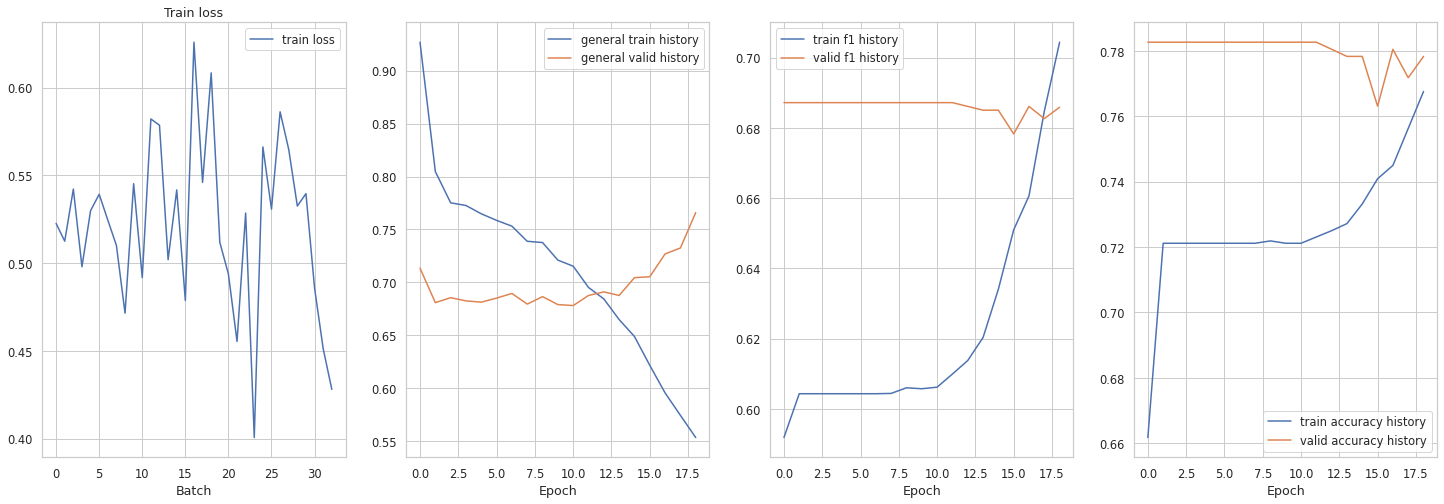

Epoch: 20 | Time: 1m 38s
	Train Loss: 0.522 | Train PPL:   1.685
	 Val. Loss: 0.756 |  Val. PPL:   2.130
	 Train. F1: 0.743 |  Val. F1: 0.675
	 Train. Acc: 0.789 |  Val. Acc: 0.746


In [ ]:
model = train_model(model, model_name, train_loader, val_loader, opt, loss_func, CLIP, N_EPOCHS)

In [ ]:
# Посчитаем метрики на тестовой выборке
print('Метрики, рассчитанные на тестовой выборке. Лучшая модель по loss')
model.load_state_dict(torch.load(os.path.join(MODELS_DIR, f'best-loss-{model_name}.pt')))
inference(model, test_loader)

Метрики, рассчитанные на тестовой выборке. Лучшая модель по loss


  0%|          | 0/14 [00:00<?, ?it/s]

F1-score on test dataset: 0.627
Accuracy score on test dataset: 0.738


In [ ]:
# Посчитаем метрики на тестовой выборке
print('Метрики, рассчитанные на тестовой выборке. Лучшая модель по f1')
model.load_state_dict(torch.load(os.path.join(MODELS_DIR, f'best-f1-{model_name}.pt')))
inference(model, test_loader)

Метрики, рассчитанные на тестовой выборке. Лучшая модель по f1


  0%|          | 0/14 [00:00<?, ?it/s]

F1-score on test dataset: 0.627
Accuracy score on test dataset: 0.738
